In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from tqdm.notebook import trange, tqdm
import random

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.distributions import Categorical
import sympy
import types

# Patch: For newer SymPy (>=1.13) where sympy.printing is removed
if not hasattr(sympy, "printing"):
    sympy.printing = types.SimpleNamespace()

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision

# HuggingFace transformers
from transformers import AutoTokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

torch.backends.cuda.matmul.allow_tf32 = True

In [2]:
# Hyperparameters
learning_rate = 1e-4
image_size = 128
nepochs = 15
batch_size = 128

# ======================
# Dataset Paths (Kaggle version)
# ======================
data_set_root = "/kaggle/input/coco-image-caption"

# Training set
train_image_path = os.path.join(data_set_root, "train2014", "train2014")
train_ann_file = os.path.join(
    data_set_root, 
    "annotations_trainval2014", "annotations", "captions_train2014.json"
)

# Validation set
val_image_path = os.path.join(data_set_root, "val2017", "val2017")
val_ann_file = os.path.join(
    data_set_root, 
    "annotations_trainval2017", "annotations", "captions_val2017.json"
)


In [3]:
# ======================
# Data Processing & Tokenization
# ======================
class SampleCaption(nn.Module):
    def __call__(self, sample):
        rand_index = random.randint(0, len(sample) - 1)
        return sample[rand_index]

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5)
]) 

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
]) 

# Load datasets
train_dataset = datasets.CocoCaptions(
    root=train_image_path,
    annFile=train_ann_file,
    transform=train_transform,
    target_transform=SampleCaption()
)

val_dataset = datasets.CocoCaptions(
    root=val_image_path,
    annFile=val_ann_file,
    transform=val_transform,
    target_transform=SampleCaption()
)

# Data loaders
data_loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
data_loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


loading annotations into memory...
Done (t=1.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


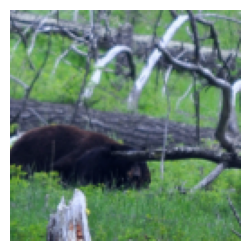

Sample Caption: A big black bear laying in the grass surrounded by trees.


In [4]:
# ======================
# Quick Visual Check
# ======================
dataiter = next(iter(data_loader_val))
test_images, test_captions = dataiter

plt.figure(figsize=(3, 3))
out = torchvision.utils.make_grid(test_images[0:1], 1, normalize=True)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis("off")
plt.show()

print("Sample Caption:", test_captions[0])

In [5]:
# We'll use a pre-built Tokenizer for the BERT Model
# https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.vocab_size

# Tokenize the sample captions from the validation batch
tokens = tokenizer(test_captions, padding=True, truncation=True, return_tensors="pt")

# Attention mask
tokens['attention_mask']

# Take the token IDs for the first caption
token_ids = tokens['input_ids'][0]

# All token IDs
tokens['input_ids']

# Decode the first caption's token IDs back to text
print(tokenizer.decode(token_ids))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

[CLS] a big black bear laying in the grass surrounded by trees. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [6]:
class TokenDrop(nn.Module):
    """For a batch of token indices, randomly replace a non-special token.
    
    Args:
        prob (float): probability of dropping a token
        blank_token (int): index for the blank token
        eos_token (int): index for the end-of-sequence token
    """
    def __init__(self, prob=0.1, blank_token=1, eos_token=102):
        super(TokenDrop, self).__init__()
        self.prob = prob
        self.eos_token = eos_token
        self.blank_token = blank_token

    def __call__(self, sample):
        # Randomly sample a Bernoulli distribution with p=prob
        mask = torch.bernoulli(self.prob * torch.ones_like(sample)).long()
        
        # Only replace if the token is not the EOS token
        can_drop = (~(sample == self.eos_token)).long()
        mask = mask * can_drop
        
        # Do not replace the first token (often special token like [CLS] or <SOS>)
        mask[:, 0] = torch.zeros_like(mask[:, 0]).long()
        
        # Replace selected tokens with the blank token
        replace_with = (self.blank_token * torch.ones_like(sample)).long()
        sample_out = (1 - mask) * sample + mask * replace_with
        
        return sample_out

**Encoder Decoder Network**

In [7]:
def extract_patches(image_tensor, patch_size=16):
    # Get the dimensions of the image tensor
    bs, c, h, w = image_tensor.size()
    
    # Define the Unfold layer with appropriate parameters
    unfold = torch.nn.Unfold(kernel_size=patch_size, stride=patch_size)
    
    # Apply Unfold to the image tensor
    unfolded = unfold(image_tensor)
    
    # Reshape the unfolded tensor to match the desired output shape
    # Output shape: BSxLxH, where L is the number of patches in each dimension
    unfolded = unfolded.transpose(1, 2).reshape(bs, -1, c * patch_size * patch_size)
    
    return unfolded


# Sinusoidal positional embeddings
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


# Attention block
class AttentionBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, masking=True):
        super(AttentionBlock, self).__init__()
        self.masking = masking
        self.multihead_attn = nn.MultiheadAttention(hidden_size,
                                                    num_heads=num_heads,
                                                    batch_first=True,
                                                    dropout=0.0)

    def forward(self, x_in, kv_in, key_mask=None):
        # Apply causal masking if enabled
        if self.masking:
            bs, l, h = x_in.shape
            mask = torch.triu(torch.ones(l, l, device=x_in.device), 1).bool()
        else:
            mask = None
            
        return self.multihead_attn(x_in, kv_in, kv_in, attn_mask=mask, 
                                   key_padding_mask=key_mask)[0]


# Transformer block
class TransformerBlock(nn.Module):
    def __init__(self, hidden_size=128, num_heads=4, decoder=False, masking=True):
        super(TransformerBlock, self).__init__()
        self.decoder = decoder
        self.norm1 = nn.LayerNorm(hidden_size)
        self.attn1 = AttentionBlock(hidden_size=hidden_size, num_heads=num_heads, 
                                    masking=masking)
        
        if self.decoder:
            self.norm2 = nn.LayerNorm(hidden_size)
            self.attn2 = AttentionBlock(hidden_size=hidden_size, 
                                        num_heads=num_heads, masking=False)
        
        self.norm_mlp = nn.LayerNorm(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 4),
            nn.ELU(),
            nn.Linear(hidden_size * 4, hidden_size)
        )
                
    def forward(self, x, input_key_mask=None, cross_key_mask=None, kv_cross=None):
        x = self.attn1(x, x, key_mask=input_key_mask) + x
        x = self.norm1(x)

        if self.decoder:
            x = self.attn2(x, kv_cross, key_mask=cross_key_mask) + x
            x = self.norm2(x)

        x = self.mlp(x) + x
        return self.norm_mlp(x)


# Decoder module
class Decoder(nn.Module):
    def __init__(self, num_emb, hidden_size=128, num_layers=3, num_heads=4):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(num_emb, hidden_size)
        self.embedding.weight.data = 0.001 * self.embedding.weight.data
        self.pos_emb = SinusoidalPosEmb(hidden_size)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, decoder=True) 
            for _ in range(num_layers)
        ])
                
        self.fc_out = nn.Linear(hidden_size, num_emb)
        
    def forward(self, input_seq, encoder_output, input_padding_mask=None, 
                encoder_padding_mask=None):        
        input_embs = self.embedding(input_seq)
        bs, l, h = input_embs.shape

        seq_indx = torch.arange(l, device=input_seq.device)
        pos_emb = self.pos_emb(seq_indx).reshape(1, l, h).expand(bs, l, h)
        embs = input_embs + pos_emb
        
        for block in self.blocks:
            embs = block(embs, 
                         input_key_mask=input_padding_mask, 
                         cross_key_mask=encoder_padding_mask, 
                         kv_cross=encoder_output)
        
        return self.fc_out(embs)


# Vision encoder
class VisionEncoder(nn.Module):
    def __init__(self, image_size, channels_in, patch_size=16, hidden_size=128, 
                 num_layers=3, num_heads=4):
        super(VisionEncoder, self).__init__()
        
        self.patch_size = patch_size
        self.fc_in = nn.Linear(channels_in * patch_size * patch_size, hidden_size)
        
        seq_length = (image_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.empty(1, seq_length, hidden_size).normal_(std=0.02))
        
        self.blocks = nn.ModuleList([
            TransformerBlock(hidden_size, num_heads, decoder=False, masking=False) 
            for _ in range(num_layers)
        ])
                
    def forward(self, image):  
        bs = image.shape[0]
        patch_seq = extract_patches(image, patch_size=self.patch_size)
        patch_emb = self.fc_in(patch_seq)
        embs = patch_emb + self.pos_embedding
        
        for block in self.blocks:
            embs = block(embs)
        
        return embs


# Vision encoder-decoder
class VisionEncoderDecoder(nn.Module):
    def __init__(self, image_size, channels_in, num_emb, patch_size=16, 
                 hidden_size=128, num_layers=(3, 3), num_heads=4):
        super(VisionEncoderDecoder, self).__init__()
        
        self.encoder = VisionEncoder(image_size=image_size, channels_in=channels_in, 
                                     patch_size=patch_size, hidden_size=hidden_size, 
                                     num_layers=num_layers[0], num_heads=num_heads)
        
        self.decoder = Decoder(num_emb=num_emb, hidden_size=hidden_size, 
                               num_layers=num_layers[1], num_heads=num_heads)

    def forward(self, input_image, target_seq, padding_mask):
        bool_padding_mask = padding_mask == 0
        encoded_seq = self.encoder(image=input_image)
        decoded_seq = self.decoder(input_seq=target_seq, 
                                   encoder_output=encoded_seq, 
                                   input_padding_mask=bool_padding_mask)
        return decoded_seq


**Model and Optimizer**

In [8]:
# Check if GPU is available, set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Embedding Size
hidden_size = 192

# Number of Transformer blocks for the (Encoder, Decoder)
num_layers = (6, 6)

# MultiheadAttention Heads
num_heads = 8

# Size of the patches
patch_size = 8

# Create model
caption_model = VisionEncoderDecoder(
    image_size=image_size,
    channels_in=test_images.shape[1],
    num_emb=tokenizer.vocab_size,
    patch_size=patch_size,
    num_layers=num_layers,
    hidden_size=hidden_size,
    num_heads=num_heads
).to(device)

# Initialize the optimizer with above parameters
optimizer = optim.Adam(caption_model.parameters(), lr=learning_rate)

# Mixed precision scaler
scaler = torch.amp.GradScaler(device="cuda")


# Define the loss function
loss_fn = nn.CrossEntropyLoss(reduction="none")

# Token dropout instance
td = TokenDrop(0.5)

# Initialize the training loss logger
training_loss_logger = []


In [9]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in caption_model.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 18067194 (Approximately 18 Million) Parameters!


In [11]:
from tqdm import trange

# Iterate over epochs
for epoch in trange(0, nepochs, desc="Epoch"):
    caption_model.train()
    epoch_loss = 0
    steps = 0
    
    for images, captions in data_loader_train:
        images = images.to(device)
        
        # Tokenize and preprocess captions
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]
        
        # Shift tokens for target
        target_ids = torch.cat(
            (token_ids[:, 1:], torch.zeros(bs, 1, device=device).long()), dim=1
        )
        
        tokens_in = td(token_ids)  # Transform tokens if needed
        
        with torch.amp.autocast('cuda'):
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)
            loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        training_loss_logger.append(loss.item())
        epoch_loss += loss.item()
        steps += 1
    
    avg_loss = epoch_loss / steps
    print(f"Epoch {epoch+1}/{nepochs} - Avg Loss: {avg_loss:.4f}")


Epoch:   7%|▋         | 1/15 [04:24<1:01:40, 264.34s/it]

Epoch 1/15 - Avg Loss: 2.7445


Epoch:  13%|█▎        | 2/15 [08:39<56:09, 259.22s/it]  

Epoch 2/15 - Avg Loss: 2.2236


Epoch:  20%|██        | 3/15 [13:23<54:06, 270.52s/it]

Epoch 3/15 - Avg Loss: 2.0753


Epoch:  27%|██▋       | 4/15 [18:01<50:06, 273.31s/it]

Epoch 4/15 - Avg Loss: 1.9669


Epoch:  33%|███▎      | 5/15 [22:33<45:29, 272.98s/it]

Epoch 5/15 - Avg Loss: 1.9297


Epoch:  40%|████      | 6/15 [27:00<40:36, 270.71s/it]

Epoch 6/15 - Avg Loss: 1.9107


Epoch:  47%|████▋     | 7/15 [31:46<36:45, 275.70s/it]

Epoch 7/15 - Avg Loss: 1.8786


Epoch:  53%|█████▎    | 8/15 [36:14<31:53, 273.41s/it]

Epoch 8/15 - Avg Loss: 1.7952


Epoch:  60%|██████    | 9/15 [40:37<27:00, 270.07s/it]

Epoch 9/15 - Avg Loss: 1.7899


Epoch:  67%|██████▋   | 10/15 [45:11<22:36, 271.28s/it]

Epoch 10/15 - Avg Loss: 1.7856


Epoch:  73%|███████▎  | 11/15 [49:34<17:55, 268.86s/it]

Epoch 11/15 - Avg Loss: 1.7483


Epoch:  80%|████████  | 12/15 [54:01<13:24, 268.12s/it]

Epoch 12/15 - Avg Loss: 1.7253


Epoch:  87%|████████▋ | 13/15 [58:35<09:00, 270.08s/it]

Epoch 13/15 - Avg Loss: 1.7158


Epoch:  93%|█████████▎| 14/15 [1:03:16<04:33, 273.36s/it]

Epoch 14/15 - Avg Loss: 1.7031


Epoch: 100%|██████████| 15/15 [1:07:51<00:00, 271.41s/it]

Epoch 15/15 - Avg Loss: 1.6966


In [21]:
from tqdm import trange
import torch

# Continue training for 20 more epochs starting from 15
start_epoch = 15
extra_epochs = 20

for epoch in trange(start_epoch, start_epoch + extra_epochs, desc="Epoch"):
    caption_model.train()
    epoch_loss = 0
    steps = 0
    
    for images, captions in data_loader_train:
        images = images.to(device)
        
        # Tokenize and preprocess captions
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens['input_ids'].to(device)
        padding_mask = tokens['attention_mask'].to(device)
        bs = token_ids.shape[0]
        
        # Shift tokens for target
        target_ids = torch.cat(
            (token_ids[:, 1:], torch.zeros(bs, 1, device=device).long()), dim=1
        )
        
        tokens_in = td(token_ids)  # Transform tokens if needed
        
        with torch.amp.autocast('cuda'):
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)
            loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        training_loss_logger.append(loss.item())
        epoch_loss += loss.item()
        steps += 1
    
    avg_loss = epoch_loss / steps
    print(f"Epoch {epoch+1}/{start_epoch + extra_epochs} - Avg Loss: {avg_loss:.4f}")
    
    # Save after every epoch
    torch.save(caption_model.state_dict(), f"caption_model_epoch{epoch+1}.pth")


Epoch:   5%|▌         | 1/20 [04:26<1:24:14, 266.04s/it]

Epoch 16/35 - Avg Loss: 1.6572


Epoch:  10%|█         | 2/20 [08:54<1:20:10, 267.24s/it]

Epoch 17/35 - Avg Loss: 1.6605


Epoch:  15%|█▌        | 3/20 [13:16<1:15:01, 264.81s/it]

Epoch 18/35 - Avg Loss: 1.6369


Epoch:  25%|██▌       | 5/20 [22:05<1:06:09, 264.61s/it]

Epoch 20/35 - Avg Loss: 1.6184


Epoch:  30%|███       | 6/20 [26:28<1:01:37, 264.10s/it]

Epoch 21/35 - Avg Loss: 1.6283


Epoch:  35%|███▌      | 7/20 [31:02<57:55, 267.35s/it]  

Epoch 22/35 - Avg Loss: 1.6036


Epoch:  40%|████      | 8/20 [35:40<54:10, 270.85s/it]

Epoch 23/35 - Avg Loss: 1.6024


Epoch:  45%|████▌     | 9/20 [40:08<49:27, 269.76s/it]

Epoch 24/35 - Avg Loss: 1.5940


Epoch:  50%|█████     | 10/20 [44:23<44:13, 265.33s/it]

Epoch 25/35 - Avg Loss: 1.5698


Epoch:  50%|█████     | 10/20 [47:02<47:02, 282.26s/it]


KeyboardInterrupt: 

In [22]:
# Save the partially trained model (after epoch 18)
torch.save(caption_model.state_dict(), "caption_model_epoch18.pth")
print("Model saved as caption_model_epoch18.pth")


Model saved as caption_model_epoch18.pth


In [15]:
from tqdm import trange
import os, time, torch

# --- config ---
start_epoch = 25          # you already trained to 25
extra_epochs = 50         # run 50 more
end_epoch = start_epoch + extra_epochs

# where to save
ckpt_dir = "/kaggle/working/checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

for epoch in trange(start_epoch, end_epoch, desc="Epoch"):
    caption_model.train()
    epoch_loss = 0.0
    steps = 0
    t0 = time.time()

    for images, captions in data_loader_train:
        images = images.to(device, non_blocking=True)

        # Tokenize captions on CPU; move tensors to device
        tokens = tokenizer(captions, padding=True, truncation=True, return_tensors="pt")
        token_ids = tokens["input_ids"].to(device, non_blocking=True)
        padding_mask = tokens["attention_mask"].to(device, non_blocking=True)
        bs = token_ids.size(0)

        # Shift for next-token prediction
        target_ids = torch.cat(
            (token_ids[:, 1:], torch.zeros(bs, 1, dtype=torch.long, device=device)),
            dim=1
        )

        tokens_in = td(token_ids)  # your TokenDrop

        with torch.amp.autocast('cuda'):
            pred = caption_model(images, tokens_in, padding_mask=padding_mask)
            loss = (loss_fn(pred.transpose(1, 2), target_ids) * padding_mask).mean()

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        training_loss_logger.append(loss.item())
        epoch_loss += loss.item()
        steps += 1

    avg_loss = epoch_loss / max(steps, 1)
    print(f"Epoch {epoch+1}/{end_epoch} - Avg Loss: {avg_loss:.4f} - {time.time()-t0:.1f}s")

    # --- save checkpoints every epoch ---
    epoch_ckpt  = os.path.join(ckpt_dir, f"caption_model_epoch{epoch+1}.pth")
    latest_ckpt = os.path.join(ckpt_dir, "caption_model_latest.pth")
    torch.save(caption_model.state_dict(), epoch_ckpt)
    torch.save(caption_model.state_dict(), latest_ckpt)

    # If you also want optimizer/scaler state for true resume, save this instead:
    # full_state = {
    #     "epoch": epoch + 1,
    #     "model_state_dict": caption_model.state_dict(),
    #     "optimizer_state_dict": optimizer.state_dict(),
    #     "scaler_state_dict": scaler.state_dict(),
    #     "avg_loss": avg_loss,
    # }
    # torch.save(full_state, os.path.join(ckpt_dir, f"full_state_epoch{epoch+1}.pth"))
    # torch.save(full_state, os.path.join(ckpt_dir, "full_state_latest.pth"))


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 26/75 - Avg Loss: 1.5714 - 365.2s


Epoch:   2%|▏         | 1/50 [06:05<4:58:26, 365.45s/it]

Epoch 27/75 - Avg Loss: 1.5900 - 249.3s


Epoch:   4%|▍         | 2/50 [10:15<3:57:49, 297.29s/it]

Epoch 28/75 - Avg Loss: 1.5913 - 247.0s


Epoch:   6%|▌         | 3/50 [14:22<3:34:59, 274.45s/it]

Epoch 29/75 - Avg Loss: 1.5947 - 251.1s


Epoch:   8%|▊         | 4/50 [18:33<3:23:27, 265.37s/it]

Epoch 30/75 - Avg Loss: 1.5770 - 251.1s


Epoch:  10%|█         | 5/50 [22:45<3:15:14, 260.32s/it]

Epoch 31/75 - Avg Loss: 1.5661 - 248.5s


Epoch:  12%|█▏        | 6/50 [26:53<3:08:02, 256.42s/it]

Epoch 32/75 - Avg Loss: 1.5576 - 248.0s


Epoch:  14%|█▍        | 7/50 [31:02<3:01:52, 253.77s/it]

Epoch 33/75 - Avg Loss: 1.5721 - 247.9s


Epoch:  16%|█▌        | 8/50 [35:10<2:56:23, 251.98s/it]

Epoch 34/75 - Avg Loss: 1.5588 - 247.3s


Epoch:  18%|█▊        | 9/50 [39:17<2:51:14, 250.60s/it]

Epoch 35/75 - Avg Loss: 1.5608 - 249.0s


Epoch:  20%|██        | 10/50 [43:27<2:46:47, 250.19s/it]

Epoch 36/75 - Avg Loss: 1.5624 - 248.0s


Epoch:  22%|██▏       | 11/50 [47:35<2:42:14, 249.60s/it]

Epoch 37/75 - Avg Loss: 1.5431 - 247.0s


Epoch:  24%|██▍       | 12/50 [51:42<2:37:38, 248.91s/it]

Epoch 38/75 - Avg Loss: 1.5376 - 250.2s


Epoch:  26%|██▌       | 13/50 [55:53<2:33:47, 249.39s/it]

Epoch 39/75 - Avg Loss: 1.5342 - 252.4s


Epoch:  28%|██▊       | 14/50 [1:00:06<2:30:14, 250.40s/it]

Epoch 40/75 - Avg Loss: 1.5372 - 252.0s


Epoch:  30%|███       | 15/50 [1:04:18<2:26:23, 250.97s/it]

Epoch 41/75 - Avg Loss: 1.5343 - 250.8s


Epoch:  32%|███▏      | 16/50 [1:08:29<2:22:14, 251.00s/it]

Epoch 42/75 - Avg Loss: 1.5222 - 250.1s


Epoch:  34%|███▍      | 17/50 [1:12:39<2:17:57, 250.82s/it]

Epoch 43/75 - Avg Loss: 1.5479 - 252.4s


Epoch:  36%|███▌      | 18/50 [1:16:52<2:14:04, 251.38s/it]

Epoch 44/75 - Avg Loss: 1.5158 - 250.3s


Epoch:  38%|███▊      | 19/50 [1:21:03<2:09:45, 251.14s/it]

Epoch 45/75 - Avg Loss: 1.5567 - 253.3s


Epoch:  40%|████      | 20/50 [1:25:16<2:05:56, 251.87s/it]

Epoch 46/75 - Avg Loss: 1.5245 - 248.7s


Epoch:  42%|████▏     | 21/50 [1:29:25<2:01:18, 250.99s/it]

Epoch 47/75 - Avg Loss: 1.5333 - 249.5s


Epoch:  44%|████▍     | 22/50 [1:33:35<1:56:57, 250.63s/it]

Epoch 48/75 - Avg Loss: 1.5313 - 248.6s


Epoch:  46%|████▌     | 23/50 [1:37:44<1:52:32, 250.11s/it]

Epoch 49/75 - Avg Loss: 1.5057 - 247.5s


Epoch:  48%|████▊     | 24/50 [1:41:52<1:48:04, 249.42s/it]

Epoch 50/75 - Avg Loss: 1.5231 - 246.4s


Epoch:  50%|█████     | 25/50 [1:45:58<1:43:35, 248.61s/it]

Epoch 51/75 - Avg Loss: 1.5145 - 247.3s


Epoch:  52%|█████▏    | 26/50 [1:50:06<1:39:19, 248.30s/it]

Epoch 52/75 - Avg Loss: 1.5016 - 248.0s


Epoch:  54%|█████▍    | 27/50 [1:54:14<1:35:10, 248.30s/it]

Epoch 53/75 - Avg Loss: 1.5172 - 246.8s


Epoch:  56%|█████▌    | 28/50 [1:58:21<1:30:54, 247.95s/it]

Epoch 54/75 - Avg Loss: 1.5116 - 246.7s


Epoch:  58%|█████▊    | 29/50 [2:02:28<1:26:40, 247.66s/it]

Epoch 55/75 - Avg Loss: 1.4862 - 248.4s


Epoch:  60%|██████    | 30/50 [2:06:37<1:22:39, 247.95s/it]

Epoch 56/75 - Avg Loss: 1.5191 - 246.0s


Epoch:  62%|██████▏   | 31/50 [2:10:43<1:18:21, 247.47s/it]

Epoch 57/75 - Avg Loss: 1.5255 - 246.2s


Epoch:  64%|██████▍   | 32/50 [2:14:50<1:14:09, 247.18s/it]

Epoch 58/75 - Avg Loss: 1.4992 - 247.5s


Epoch:  66%|██████▌   | 33/50 [2:18:58<1:10:05, 247.36s/it]

Epoch 59/75 - Avg Loss: 1.4947 - 247.1s


Epoch:  68%|██████▊   | 34/50 [2:23:05<1:05:58, 247.38s/it]

Epoch 60/75 - Avg Loss: 1.5007 - 249.3s


Epoch:  70%|███████   | 35/50 [2:27:15<1:02:00, 248.04s/it]

Epoch 61/75 - Avg Loss: 1.4980 - 248.4s


Epoch:  72%|███████▏  | 36/50 [2:31:23<57:55, 248.26s/it]  

Epoch 62/75 - Avg Loss: 1.4963 - 248.7s


Epoch:  74%|███████▍  | 37/50 [2:35:32<53:50, 248.47s/it]

Epoch 63/75 - Avg Loss: 1.4914 - 248.0s


Epoch:  76%|███████▌  | 38/50 [2:39:41<49:40, 248.41s/it]

Epoch 64/75 - Avg Loss: 1.4894 - 247.0s


Epoch:  78%|███████▊  | 39/50 [2:43:48<45:28, 248.06s/it]

Epoch 65/75 - Avg Loss: 1.4892 - 248.0s


Epoch:  80%|████████  | 40/50 [2:47:56<41:21, 248.14s/it]

Epoch 66/75 - Avg Loss: 1.5041 - 247.0s


Epoch:  82%|████████▏ | 41/50 [2:52:03<37:10, 247.87s/it]

Epoch 67/75 - Avg Loss: 1.5078 - 248.5s


Epoch:  84%|████████▍ | 42/50 [2:56:12<33:05, 248.15s/it]

Epoch 68/75 - Avg Loss: 1.4775 - 247.8s


Epoch:  86%|████████▌ | 43/50 [3:00:20<28:56, 248.14s/it]

Epoch 69/75 - Avg Loss: 1.4802 - 248.5s


Epoch:  88%|████████▊ | 44/50 [3:04:29<24:49, 248.33s/it]

Epoch 70/75 - Avg Loss: 1.4865 - 247.4s


Epoch:  90%|█████████ | 45/50 [3:08:37<20:40, 248.13s/it]

Epoch 71/75 - Avg Loss: 1.4800 - 248.9s


Epoch:  92%|█████████▏| 46/50 [3:12:46<16:33, 248.45s/it]

Epoch 72/75 - Avg Loss: 1.4784 - 248.6s


Epoch:  94%|█████████▍| 47/50 [3:16:55<12:25, 248.59s/it]

Epoch 73/75 - Avg Loss: 1.4747 - 248.2s


Epoch:  96%|█████████▌| 48/50 [3:21:03<08:17, 248.56s/it]

Epoch 74/75 - Avg Loss: 1.4823 - 248.6s


Epoch:  98%|█████████▊| 49/50 [3:25:12<04:08, 248.67s/it]

Epoch 75/75 - Avg Loss: 1.4620 - 247.3s


Epoch: 100%|██████████| 50/50 [3:29:20<00:00, 251.21s/it]


In [10]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=6e910fc749e603d5bce54db59d5f3a3442cc1778426cc24c95fefa88d9b42841
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [24]:
import pandas as pd
import torch

# Load metrics
metrics = pd.read_csv("metrics_log.csv")
print(metrics.head())

# Example: choose best epoch based on BLEU
best_epoch = metrics.loc[metrics['BLEU'].idxmax(), 'Epoch']
print(f"Best epoch based on BLEU: {best_epoch}")

# Load that model
best_model_path = f"caption_model_epoch{int(best_epoch)}.pth"
caption_model.load_state_dict(torch.load(best_model_path))
caption_model.to(device)
caption_model.eval()
print("Loaded best model from:", best_model_path)


   Epoch  Avg_Loss      BLEU   ROUGE_L    METEOR
0     26  1.466790  0.045323  0.369082  0.232362
1     27  1.457061  0.045534  0.371699  0.232626
2     28  1.461737  0.045244  0.372519  0.232718
3     29  1.447862  0.045946  0.374081  0.233854
Best epoch based on BLEU: 29
Loaded best model from: caption_model_epoch29.pth


In [11]:
checkpoint_path = "/kaggle/input/best-epoch/caption_model_epoch29.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

try:
    checkpoint = torch.load(checkpoint_path, map_location=device)
    if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
        caption_model.load_state_dict(checkpoint["model_state_dict"])
    else:
        caption_model.load_state_dict(checkpoint)  # if model was saved directly
except Exception as e:
    print("Error loading checkpoint:", e)

caption_model.to(device)
caption_model.eval()


VisionEncoderDecoder(
  (encoder): VisionEncoder(
    (fc_in): Linear(in_features=192, out_features=192, bias=True)
    (blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn1): AttentionBlock(
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
          )
        )
        (norm_mlp): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=192, out_features=768, bias=True)
          (1): ELU(alpha=1.0)
          (2): Linear(in_features=768, out_features=192, bias=True)
        )
      )
    )
  )
  (decoder): Decoder(
    (embedding): Embedding(30522, 192)
    (pos_emb): SinusoidalPosEmb()
    (blocks): ModuleList(
      (0-5): 6 x TransformerBlock(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn1): Attentio

In [12]:
sos_token_id = tokenizer.bos_token_id or 101  # fallback
eos_token_id = tokenizer.eos_token_id or 102  # fallback


In [13]:
def generate_caption(model, image, tokenizer, device, max_len=50, temp=0.5):
    model.eval()
    with torch.no_grad():
        # Encode image
        with torch.amp.autocast("cuda"):
            image_embedding = model.encoder(image.to(device))
        
        # Start token
        log_tokens = [torch.tensor([[sos_token_id]], device=device)]
        
        for _ in range(max_len):
            input_tokens = torch.cat(log_tokens, dim=1).to(device)
            data_pred = model.decoder(input_tokens, image_embedding)
            
            # Sample next token
            dist = Categorical(logits=data_pred[:, -1] / temp)
            next_token = dist.sample().reshape(1, 1)
            log_tokens.append(next_token)
            
            if next_token.item() == eos_token_id:
                break
        
        pred_tensor = torch.cat(log_tokens, dim=1).cpu()
        pred_text = tokenizer.decode(pred_tensor[0].tolist(), skip_special_tokens=True)
        return pred_text


In [14]:
def evaluate_model(model, data_loader, tokenizer, device, max_len=50, temp=0.5, n_samples=5):
    model.eval()
    for i, (images, captions) in enumerate(data_loader):
        images = images.to(device)
        for b in range(min(n_samples, images.size(0))):
            pred_caption = generate_caption(model, images[b:b+1], tokenizer, device, max_len, temp)
            
            # Convert reference captions to list of ints
            if isinstance(captions[b], torch.Tensor):
                ref_ids = captions[b].cpu().tolist()
            else:
                # tokenize string captions
                ref_tokens = tokenizer(captions[b], return_tensors="pt")
                ref_ids = ref_tokens['input_ids'][0].tolist()
            
            ref_caption = tokenizer.decode(ref_ids, skip_special_tokens=True)
            
            print(f"Image {i*data_loader.batch_size+b}:")
            plt.imshow(torchvision.utils.make_grid(images[b:b+1].cpu(), normalize=True).numpy().transpose(1,2,0))
            plt.show()
            print("Reference:", ref_caption)
            print("Predicted:", pred_caption)
        break  # only first batch for quick sanity check


Image 0:


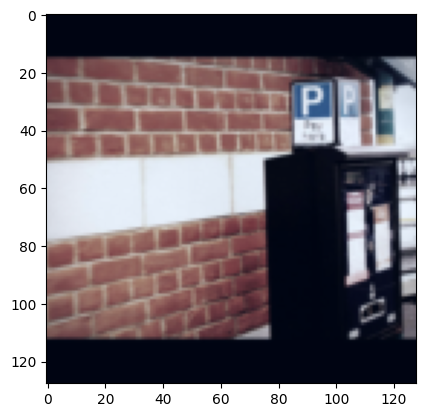

Reference: a box where you pay for your parking.
Predicted: a large building with a clock on the side.
Image 1:


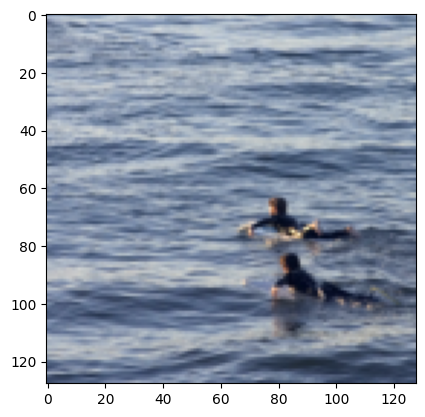

Reference: two people who are swimming in the water on surfboards.
Predicted: a bird stands on the beach under a blue sky.
Image 2:


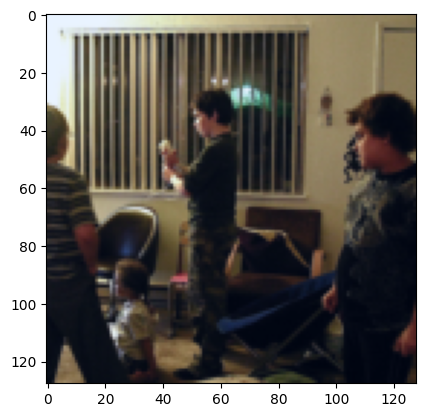

Reference: four children in a living room with one of the children holding a game controller before a television.
Predicted: a group of people standing around a table with a laptop.
Image 3:


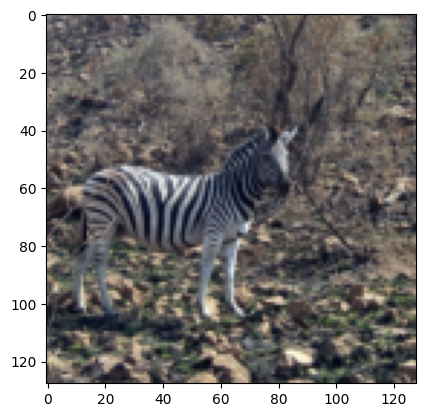

Reference: a zebra is standing on some rocky brown land.
Predicted: a zebra standing in a grassy field with trees
Image 4:


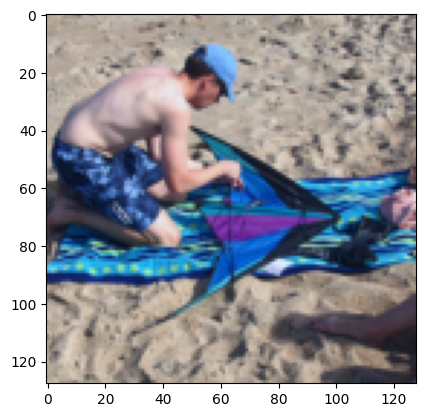

Reference: a young man on the beach assembling a kite.
Predicted: a man sitting on a bench in front of a mountain.


In [15]:
evaluate_model(caption_model, data_loader_val, tokenizer, device, max_len=50, temp=0.5)


In [16]:
pip install nltk tqdm


Note: you may need to restart the kernel to use updated packages.


In [17]:
import nltk
nltk.download("wordnet")
nltk.download("punkt")


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [18]:
import torch
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm

def evaluate_metrics(model, dataloader, tokenizer, device, max_len=50):
    model.eval()
    all_references = []
    all_candidates = []

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    total_rougeL = 0.0
    total_meteor = 0.0
    n_samples = 0

    with torch.no_grad():
        for images, captions in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)

            for b in range(images.size(0)):
                # ---- Generate prediction ----
                pred_caption = generate_caption(model, images[b:b+1], tokenizer, device, max_len=max_len)

                # ---- Reference decoding ----
                if isinstance(captions[b], torch.Tensor):
                    ref_caption = tokenizer.decode(captions[b].cpu().tolist(), skip_special_tokens=True)
                else:
                    ref_caption = str(captions[b])

                # Collect for corpus metrics
                all_candidates.append(pred_caption.split())
                all_references.append([ref_caption.split()])  # list of list for BLEU

                # ROUGE-L
                total_rougeL += scorer.score(ref_caption, pred_caption)["rougeL"].fmeasure

                # METEOR
                total_meteor += meteor_score([ref_caption.split()], pred_caption.split())

                n_samples += 1

    # ---- Final metrics ----
    bleu = corpus_bleu(all_references, all_candidates, smoothing_function=SmoothingFunction().method1)
    rougeL = total_rougeL / n_samples
    meteor = total_meteor / n_samples

    print(f"\n📊 Evaluation Results:")
    print(f"BLEU   : {bleu:.4f}")
    print(f"ROUGE-L: {rougeL:.4f}")
    print(f"METEOR : {meteor:.4f}")

    return bleu, rougeL, meteor


In [21]:
bleu, rougeL, meteor = evaluate_metrics(
    caption_model, data_loader_val, tokenizer, device, max_len=50
)


Evaluating: 100%|██████████| 40/40 [07:44<00:00, 11.61s/it]



📊 Evaluation Results:
BLEU   : 0.0355
ROUGE-L: 0.2865
METEOR : 0.1943


In [22]:
torch.save({
    "model_state_dict": caption_model.state_dict(),
    "tokenizer": tokenizer,   # optional, if you want
}, "caption_model_best.pth")
